In [1]:
import os
import shutil
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [5]:
# LSTM_Live 폴더의 모든 CSV 파일 병합
def LSTM_Live_Merge(folder_path):
    
    csv_files = []

    # 하위 폴더까지 탐색
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.csv'):
                csv_path = os.path.join(root, file)
                
                # CSV 불러오기
                df = pd.read_csv(csv_path)
                csv_files.append(df)

    # 모든 CSV 파일 병합
    if csv_files:
        combined_df = pd.concat(csv_files, ignore_index=True)
        print(f"총 {len(csv_files)}개의 CSV 파일을 병합했습니다. 데이터 크기: {combined_df.shape}")
        return combined_df
    else:
        print("병합할 CSV 파일이 없습니다.")
        return pd.DataFrame()


In [6]:
# 정렬을 위한 자연 정렬 키 함수
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

# CSV 파일 개수가 6의 배수가 아닌 경우 폴더 삭제하는 함수 (29개인 경우 경로 출력)
def delete_invalid_csv_folders(folder_path, sequence=6):
    """폴더 내 CSV 파일 개수가 sequence(6)의 배수가 아닌 경우 폴더 삭제하고, 29개인 경우 경로 출력"""
    for root, _, files in sorted(os.walk(folder_path), key=lambda x: natural_sort_key(x[0])):
        sorted_files = sorted([file for file in files if file.endswith('.csv')], key=natural_sort_key)
        file_count = len(sorted_files)

        if file_count == 0:
            continue  # CSV 파일이 없는 폴더는 건너뜀

        # CSV 파일 개수가 29개인 폴더는 경로 출력
        if file_count == 29:
            print(f"[CSV 29개] {root}")

        # CSV 파일 개수가 6의 배수가 아니면 폴더 삭제
        if file_count % sequence != 0:
            print(f"[삭제] {root}: CSV 파일 수 {file_count}개는 {sequence}의 배수가 아닙니다. 폴더를 삭제합니다.")

            # 폴더 삭제
            try:
                shutil.rmtree(root)  # 폴더 삭제
                print(f"삭제됨: {root}")
            except Exception as e:
                print(f"폴더 삭제 오류: {root} - {e}")

# 폴더 내 CSV 파일 병합
def LSTM_Capture_Merge(folder_path, sequence):
    
    csv_files = []

    for root, _, files in sorted(os.walk(folder_path), key=lambda x: natural_sort_key(x[0])):
        sorted_files = sorted([file for file in files if file.endswith('.csv')], key=natural_sort_key)
        file_count = len(sorted_files)
        
        if file_count == 0:
            continue  # CSV 파일이 없는 폴더는 건너뜀
        
        if file_count % sequence != 0:
            print(f"[제외] {root}: CSV 파일 수 {file_count}개는 {sequence}의 배수가 아닙니다.")
            continue  # sequence의 배수가 아니면 병합 제외

        for file in sorted_files:
            csv_path = os.path.join(root, file)
            csv_files.append(csv_path)

    if not csv_files:
        print("병합할 CSV 파일이 없습니다.")
        return pd.DataFrame()
    
    # CSV 파일 병합 (float_precision 추가)
    dataframes = [pd.read_csv(file, float_precision='round_trip') for file in csv_files]
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"총 {len(csv_files)}개의 CSV 파일을 병합했습니다. 데이터 크기: {combined_df.shape}")
    return combined_df

In [7]:
# 데이터 시퀀스별로 변환
def reshape_to_sequences(data, labels, seq_length):
    sequences = []
    sequence_labels = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
        sequence_labels.append(labels[i + seq_length - 1])  # 시퀀스의 마지막 레이블 사용
    return np.array(sequences), np.array(sequence_labels)

In [8]:
# 클래스 균등하게 정리
def balance_classes(df, class_column, target_samples):

    # 그룹화하여 각 클래스에서 샘플링
    balanced_df = df.groupby(class_column).apply(
        lambda x: x.sample(n=target_samples, random_state=42) if len(x) >= target_samples else x
    )
    
    # 인덱스 초기화
    balanced_df = balanced_df.reset_index(drop=True)
    return balanced_df

In [9]:
# 6의 배수가 아닌 CSV 파일이 있는 폴더 삭제 + 29개인 폴더 출력
delete_invalid_csv_folders('./Data' + '/LSTM_Capture/2. danger', sequence=6)

In [12]:
# 데이터 불러오기 및 병합
folder_path = './Data'  # 데이터 폴더 경로

df_live = LSTM_Live_Merge(folder_path + '/LSTM_Live') # LSTM_Live 폴더 병합
df_capture = LSTM_Capture_Merge(folder_path + '/LSTM_Capture', sequence=6) # LSTM_Capture 폴더 병합
df= pd.concat([df_live, df_capture], ignore_index=True) # 전체 폴더 병합

병합할 CSV 파일이 없습니다.
총 9636개의 CSV 파일을 병합했습니다. 데이터 크기: (9636, 35)


In [13]:
# 정리 전 클래스별 갯수 확인
print(df['action_class'].value_counts())

action_class
0    3318
2    3306
1    3012
Name: count, dtype: int64


In [41]:
# 클래스 균등하게 정리
df = balance_classes(df, class_column='action_class', target_samples=96)

C:\Users\User\AppData\Local\Temp\ipykernel_9396\2504395227.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(class_column).apply(


In [14]:
# 데이터프레임 확인
print(df['action_class'].value_counts())
df

action_class
0    3318
2    3306
1    3012
Name: count, dtype: int64


,kp0_x,kp0_y,kp1_x,kp1_y,kp2_x,kp2_y,kp3_x,kp3_y,kp4_x,kp4_y,...,kp12_y,kp13_x,kp13_y,kp14_x,kp14_y,kp15_x,kp15_y,kp16_x,kp16_y,action_class
0,0.465898,0.155171,0.523347,0.132365,0.417312,0.132064,0.626188,0.141910,0.356054,0.138935,...,0.554828,0.676381,0.744417,0.457153,0.733534,0.704138,0.895645,0.498265,0.871101,0
1,0.458163,0.158859,0.520402,0.135390,0.406434,0.134199,0.629726,0.142295,0.338418,0.138697,...,0.568725,0.698195,0.744871,0.454175,0.739981,0.700019,0.893639,0.510552,0.870637,0
2,0.427069,0.165217,0.493218,0.143255,0.376026,0.140980,0.611417,0.148885,0.311441,0.143064,...,0.569011,0.689467,0.747847,0.420788,0.738906,0.686374,0.887316,0.483228,0.865632,0
3,0.397619,0.166994,0.455787,0.142228,0.345399,0.141774,0.571732,0.146189,0.285154,0.144422,...,0.570573,0.637093,0.758206,0.394131,0.740048,0.644034,0.891922,0.443403,0.857245,0
4,0.451159,0.161358,0.513140,0.135386,0.397743,0.136171,0.619379,0.144817,0.333507,0.144677,...,0.576974,0.695167,0.753620,0.404994,0.746226,0.659274,0.893565,0.494259,0.859216,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9631,-1.190265,-0.930612,-1.190265,-0.930612,-1.190265,-0.930612,0.197161,0.249063,-1.190265,-0.930612,...,0.374881,0.469176,0.665744,0.416124,0.428203,0.437671,0.923040,0.457467,0.715041,2
9632,-1.234234,-0.942623,-1.234234,-0.942623,-1.234234,-0.942623,0.172746,0.220374,-1.234234,-0.942623,...,0.362826,0.447607,0.642000,0.403804,0.417638,0.438476,0.886301,0.457338,0.660545,2
9633,-1.336449,-0.888446,-1.336449,-0.888446,-1.336449,-0.888446,0.197650,0.234722,-1.336449,-0.888446,...,0.401725,0.469864,0.702058,0.377485,0.470216,0.379870,0.920516,0.387616,0.700421,2
9634,-1.325581,-0.899598,-1.325581,-0.899598,-1.325581,-0.899598,0.205407,0.236843,-1.325581,-0.899598,...,0.393664,0.452201,0.682473,0.403982,0.426828,0.402386,0.885464,0.387802,0.647328,2


In [15]:
# X, y 분리
X = df.iloc[:, :-1].values # 키포인트
y = df.iloc[:, -1].values # 클래스

In [16]:
# 레이블 원-핫 인코딩
y = to_categorical(y)

In [17]:
# 데이터 시퀀스 길이 지정
seq_length = 6  # 시퀀스 길이

# 데이터를 시퀀스 형태로 변환
X_seq, y_seq = reshape_to_sequences(X, y, seq_length)

In [18]:
# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [19]:
# LSTM 모델 정의
model = Sequential([
    LSTM(128, input_shape=(seq_length, X_train.shape[2]), return_sequences=True),
    LSTM(64),
    Dense(32, activation="relu"),
    Dense(y_train.shape[1], activation="softmax")
    ])

c:\Users\User\anaconda3\envs\action_recognition\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
 # 모델 컴파일 및 학습
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
es = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 15, mode = 'auto', restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=32, callbacks=es).history

Epoch 1/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5366 - loss: 0.9363 - val_accuracy: 0.7265 - val_loss: 0.6239
Epoch 2/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7463 - loss: 0.5808 - val_accuracy: 0.8111 - val_loss: 0.4461
Epoch 3/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8218 - loss: 0.4229 - val_accuracy: 0.8137 - val_loss: 0.4492
Epoch 4/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8798 - loss: 0.3097 - val_accuracy: 0.8651 - val_loss: 0.3310
Epoch 5/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8995 - loss: 0.2473 - val_accuracy: 0.9019 - val_loss: 0.2429
Epoch 6/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9173 - loss: 0.2139 - val_accuracy: 0.9118 - val_loss: 0.2211
Epoch 7/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9383 - loss: 0.1649 - val_accuracy: 0.9445 - val_loss: 0.1478
Epoch 8/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9537 - loss: 0.1241 - val_accu

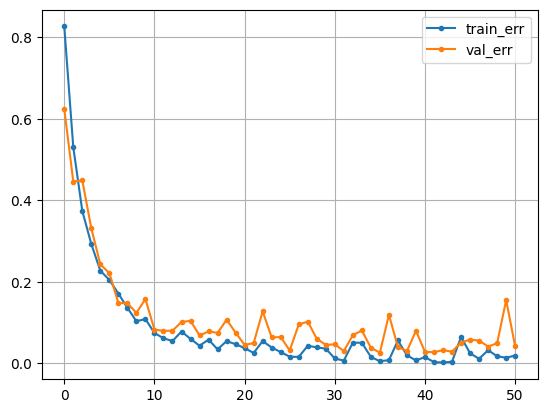

In [21]:
plt.plot(history['loss'], label = 'train_err', marker = '.')
plt.plot(history['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [22]:
# 모델 저장
output_model = './Model/LSTM.h5'
model.save(output_model)

In [23]:
# 학습된 모델 평가
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"검증 데이터 정확도: {accuracy * 100:.2f}%")

검증 데이터 정확도: 99.12%
